In [1]:
import torch

seed = 1

Autosave disabled


In [2]:
import os


data_dir = '../data/'
print(os.listdir(data_dir))

['cifar', 'data_backup', 'hashes', 'nasbench.pickle', 'nasbench_full.tfrecord', 'nasbench_only108.tfrecord', 'nb_dataset.json', 'paper_final_results', 'scales', 'test_small_split.pt', 'test_train_long.pt', 'test_valid_long.pt', 'train_labeled.pt', 'train_long.pt', 'vae_checkpoints', 'valid_labeled.pt', 'valid_long.pt']


In [ ]:
from nasbench import api

nasbench_path = os.path.join(data_dir, 'nasbench_only108.tfrecord')
nb = api.NASBench(nasbench_path)

In [4]:
nb_dataset = os.path.join(data_dir, 'nb_dataset.json')
cifar = os.path.join(data_dir, 'cifar')

In [ ]:
torch.multiprocessing.set_sharing_strategy('file_system')

from heatmap_utils import get_labeled_data


dataset_pt = os.path.join(data_dir, 'train_long.pt')
data = get_labeled_data(dataset_pt, nb, nb_dataset, cifar)

In [13]:
hashes = set()

for d in data:
    hashes.update(d['hash'])
hashes

{'0007522357ab851ea74abae9fb2d15c1',
 '00261a9591b593ceb68cd5854744e807',
 '00961d039703aa88c0eb5faa0889a64e',
 '00ab8e9798743ca93dfe76e3a373ddff',
 '00ac1ec7a2d74d205a5f2b6bce0158f0',
 '01e1e6d0a7260e29e06567650feb078c',
 '01ef56131803d7e4e79399d675ea0b42',
 '023bfb8418a28942ee4a9734e373ca67',
 '023d04e5789ed12a03567ee1e92f6a67',
 '0275b85b2e008b02ae4cf595a19a0027',
 '03ceaebcf6f00bb8c70b44266f28c2a4',
 '03e8ff7e1694ec0fa21353547bd280d4',
 '040f6a4fb99f316b89bcab32eca6b596',
 '04186a1b8ac5333749d005982e452ea3',
 '048edd503b2970f42eb556679862d8a5',
 '04c4f6c04e965c0f48d67641ee32d181',
 '04dc9a92ab97897940ba155218257444',
 '05cf16b0c0e041eec9947b7a6585726f',
 '0617e9ed1ea257599a7e8aa8300bd96f',
 '061894ae9bd443325e0bada6c0b7dc45',
 '0643c51c004d62b45ddb7f9b2b3be03d',
 '0647e27ef0ee121804cad50693361bed',
 '0653ca12160f70cca032f459e5e3feb6',
 '0740459738e9601f98671cc23670c7fe',
 '07d5b28399cee2ccfef0f21f353687d6',
 '07e09c7a1b3b42c6f613a627faa3a9fe',
 '07e1bc4650e6765660cf20f24dd62a5e',
 

In [ ]:
from info_nas.config import load_json_cfg
from info_nas.models.utils import get_hash_accuracy

config = load_json_cfg('../configs/model_config.json')

accuracies = get_hash_accuracy(hashes, nb, config)

In [41]:
import numpy as np
times = []

for h in hashes:
    t = [n['final_training_time'] for n in nb.get_metrics_from_hash(h)[1][12]]
    times.append(np.mean(t))

print(sum(times))

138070.05435689294


In [29]:
print(max(accuracies))

tensor(0.9405)


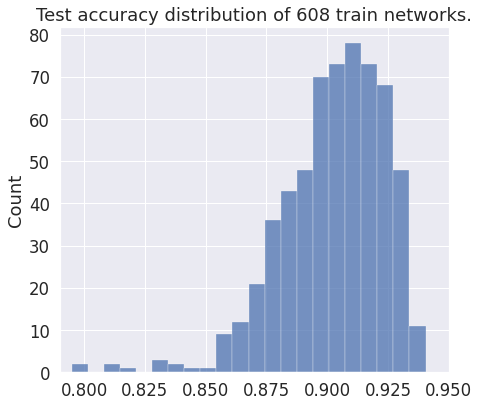

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.5)
save_dir = '.'

plt.figure(figsize=(7,6))
sns.histplot(accuracies)
plt.xlim(0.79, 0.95)
plt.title("Test accuracy distribution of 608 train networks.")
plt.tight_layout()
plt.savefig(f"{save_dir}/accdist.png")
plt.show()

In [24]:
from heatmap_utils import get_pred_and_orig

top_k = 10
orig, info, _, labels = get_pred_and_orig(data, device=torch.device('cpu'), top_k=top_k,
                                         )#batch_stop=1001)

Batch 0
Batch 1000
Batch 2000
Batch 3000
Batch 4000
Batch 5000
Batch 6000
Batch 7000
Batch 8000
Batch 9000
Batch 10000
Batch 11000
Batch 12000
Batch 13000
Batch 14000
Batch 15000
Batch 16000
Batch 17000
Batch 18000


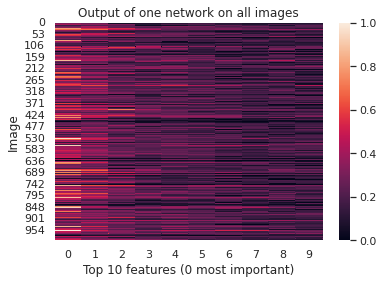

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from heatmap_utils import plot_single_heatmap, heatmap_diff

vmin = 0
vmax = 1
o = orig[:1000]

save_dir = '.'

plot_single_heatmap(o, sub_mean=False, by_row=True, vmin=vmin, vmax=vmax)
plt.xlabel('Top 10 features (0 most important)')
plt.title('Output of one network on all images')
plt.ylabel('Image')
plt.xlabel('Top 10 features (0 most important)')
plt.savefig(f"{save_dir}/heat1net.png")
plt.show()

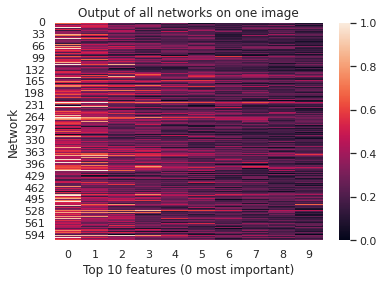

In [26]:
plot_single_heatmap(orig[0::1000], sub_mean=False, by_row=True, vmin=vmin, vmax=vmax)
plt.title('Output of all networks on one image')
plt.ylabel('Network')
plt.xlabel('Top 10 features (0 most important)')
plt.savefig(f"{save_dir}/heat1img.png")
plt.show()

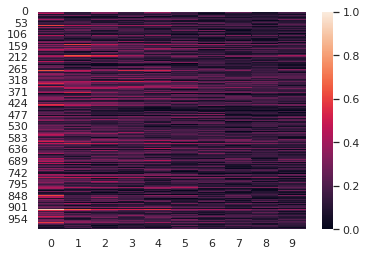

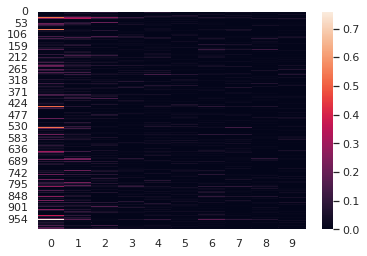

In [8]:
o_2 = orig[5000:6000]

plot_single_heatmap(o_2, sub_mean=False, by_row=True, vmin=vmin, vmax=vmax)
plt.show()

heatmap_diff(o, o_2, sub_mean=False, by_row=True, plot_it=True, use_sq=True)
plt.show()

In [9]:
orig.shape

(608000, 10)

In [27]:
import itertools
import numpy as np

k = 0
n_nets = 608
# n_nets = 100
print_freq = 1000
normalize_columns = False

from_feats = norm_orig if normalize_columns else orig
res_matrix = np.zeros((n_nets, n_nets))

divsigma = False
submean = False

for i, j in itertools.combinations(range(n_nets), 2):
    if k % print_freq == 0:
        print(i, j)
    k += 1
        
    if i == j:
        continue

    o = from_feats[i * 1000:(i + 1) * 1000]
    o_2 = from_feats[j * 1000:(j + 1) * 1000]
    diff = heatmap_diff(o, o_2, sub_mean=submean, div_by_sigma=divsigma, by_row=True, plot_it=False, use_sq=True)
    
    diff = np.sum(diff, axis=1)
    diff = diff.mean()
    
    res_matrix[i, j] = diff

0 1
1 395
3 186
4 583
6 380
8 181
9 583
11 390
13 201
15 16
16 425
18 246
20 71
21 485
23 316
25 151
26 570
28 411
30 256
32 105
33 531
35 386
37 245
39 108
40 541
42 410
44 283
46 160
47 600
49 483
51 370
53 261
55 156
56 605
58 506
60 411
62 320
64 233
66 150
68 71
69 533
71 460
73 391
75 326
77 265
79 208
81 155
83 106
84 583
86 540
88 501
90 466
92 435
94 408
96 385
98 366
100 351
102 340
104 333
106 330
108 331
110 336
112 345
114 358
116 375
118 396
120 421
122 450
124 483
126 520
128 561
130 606
133 181
135 236
137 295
139 358
141 425
143 496
145 571
148 191
150 276
152 365
154 458
156 555
159 208
161 315
163 426
165 541
168 221
170 346
172 475
175 176
177 315
179 458
181 605
184 333
186 490
189 233
191 400
193 571
196 335
198 516
201 295
203 486
206 280
208 481
211 290
213 501
216 325
218 546
221 385
224 233
226 470
229 333
231 580
234 458
237 345
240 241
242 510
245 421
248 341
251 270
253 561
256 505
259 458
262 420
265 391
268 371
271 360
274 358
277 365
280 381
283 406
286 

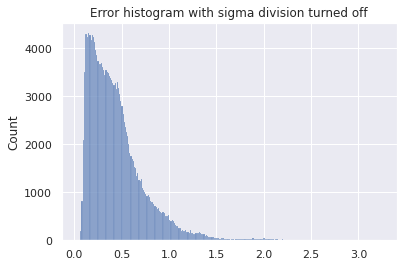

In [11]:
from heatmap_utils import plot_hist


plt.title(f"Error histogram with sigma division turned {'on' if divsigma else 'off'}")
flat = res_matrix.flatten()
flat = flat[flat > 0]
plot_hist(flat)
plt.show()

In [12]:
print(np.quantile(flat, 0.25))
np.median(flat)

0.22383517026901245


0.3773635923862457

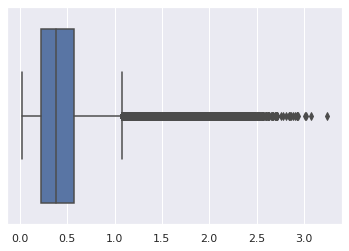

In [13]:
sns.boxplot(x=flat)
plt.show()

In [14]:
for i, j in itertools.combinations(range(n_nets), 2):
    res_matrix[j, i] = max(res_matrix[i, j], 0)

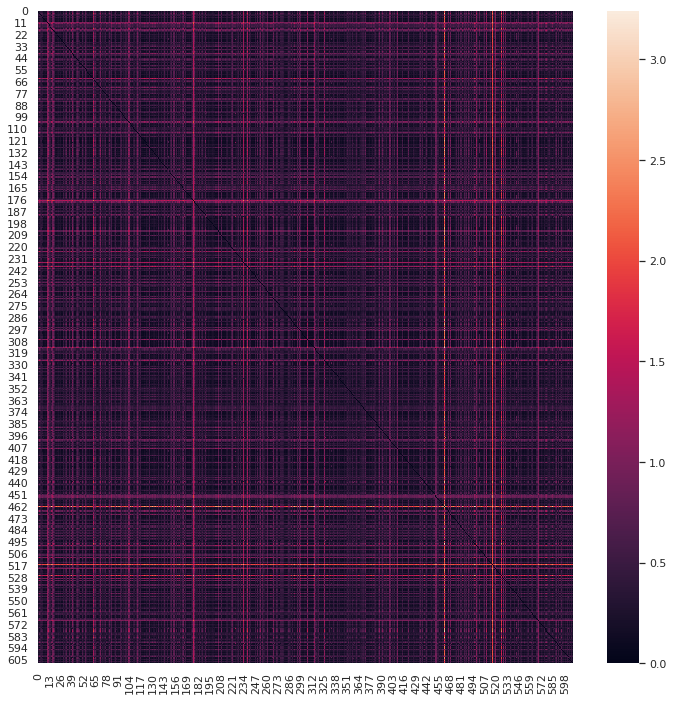

In [15]:
plt.figure(figsize=(12, 12))
plot_single_heatmap(res_matrix)
plt.show()

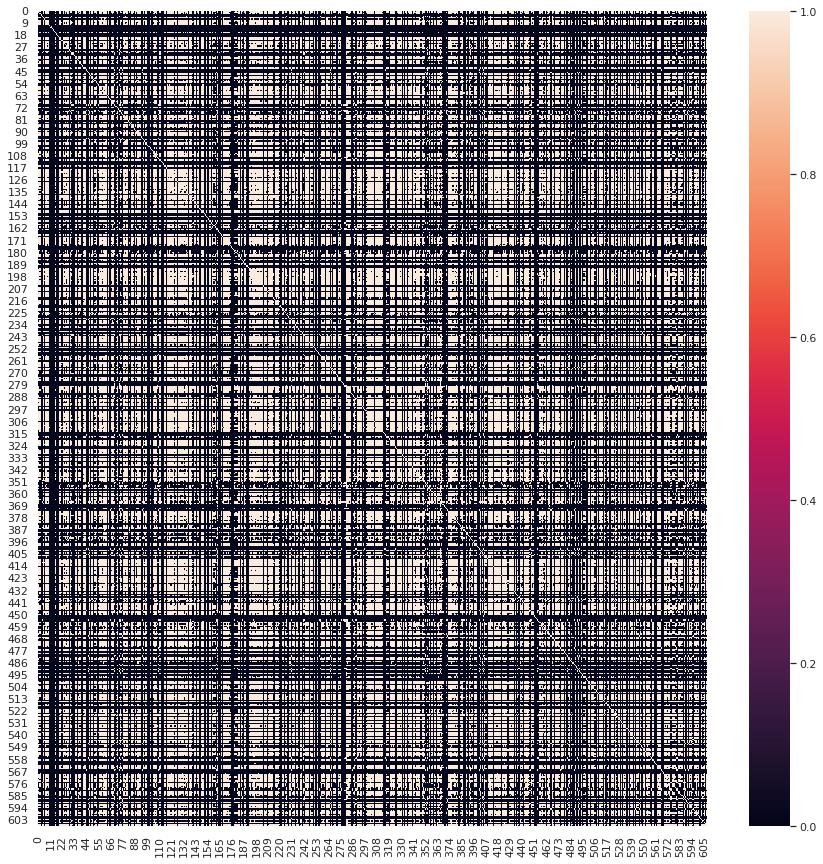

In [16]:
plt.figure(figsize=(15,15))
plot_single_heatmap((res_matrix < 0.3).astype(int))

plt.show()

In [ ]:
from sklearn.cluster import AgglomerativeClustering

for th in np.arange(0, 1, 0.1):
    
    km = AgglomerativeClustering(n_clusters=None, linkage='complete', affinity='precomputed', distance_threshold=th)
    res = km.fit_predict(res_matrix)
    uniq = np.unique(res, return_counts=True)
    
    print(round(th, 1), ' | ', sum(uniq[1] == 1), ', clusters > 2: ', sum(uniq[1] > 2))

In [28]:
from sklearn.cluster import AgglomerativeClustering

thres = 0.4


km = AgglomerativeClustering(n_clusters=None, linkage='complete', affinity='precomputed', distance_threshold=thres)
res = km.fit_predict(res_matrix)

In [ ]:
uniq = np.unique(res, return_counts=True)
print(uniq)
print(sum(uniq[1] == 1))

In [30]:
cls = 2
print(np.arange(n_nets)[res == cls])

[340 495]


In [31]:
def get_net_accuracy(net_id, what='test'):
    what = f"final_{what}_accuracy"
    
    net_hash = info['hash'][net_id * 1000]
    metrics = nb.get_metrics_from_hash(net_hash)
    
    return np.mean([m[what] for m in metrics[1][108]])

In [32]:
accs = [get_net_accuracy(i, what='test') for i in range(n_nets)]
print("mean ", np.mean(accs), "| std ", np.std(accs))

mean  0.8988011295768319 | std  0.04650399693188702


In [33]:
import pandas as pd


acc_df = []

for cluster_no, cluster_size in zip(*np.unique(res, return_counts=True)):
    if cluster_size == 1:
        continue
    
    print(cluster_no, cluster_size)
    
    net_ids = [i for i, v in enumerate(res) if v == cluster_no]
    #print(net_ids)
    accs = [get_net_accuracy(i, what='test') for i in net_ids]
    
    if cluster_size > 2:
        
        for a in accs:
            acc_df.append({'cluster': cluster_no, 'acc': a})
    
    print("mean ", np.mean(accs), "| std ", np.std(accs), "| max ", np.max(accs))
    print()
    #print(accs)
    print('----------------')
    
acc_df = pd.DataFrame(acc_df)

0 5
mean  0.9062767068545025 | std  0.007223602476646915 | max  0.9170339306195577

----------------
1 6
mean  0.916933755079905 | std  0.008204431376505087 | max  0.9304220080375671

----------------
2 2
mean  0.905982901652654 | std  0.00230368971824646 | max  0.9082865913709005

----------------
3 45
mean  0.8599203134024586 | std  0.12335914736132014 | max  0.9224759737650553

----------------
4 6
mean  0.9194155070516797 | std  0.005884148340719052 | max  0.9290531476338705

----------------
5 18
mean  0.9079712717621415 | std  0.009135814242302096 | max  0.9286191264788309

----------------
6 3
mean  0.9183248745070562 | std  0.009895462094631775 | max  0.9291199445724487

----------------
7 4
mean  0.899272158741951 | std  0.0015985596394709465 | max  0.9011418223381042

----------------
8 8
mean  0.9290698443849881 | std  0.0034780347405276844 | max  0.9364984035491943

----------------
9 4
mean  0.9167751719554265 | std  0.003549094591198758 | max  0.9210403362909952

--------

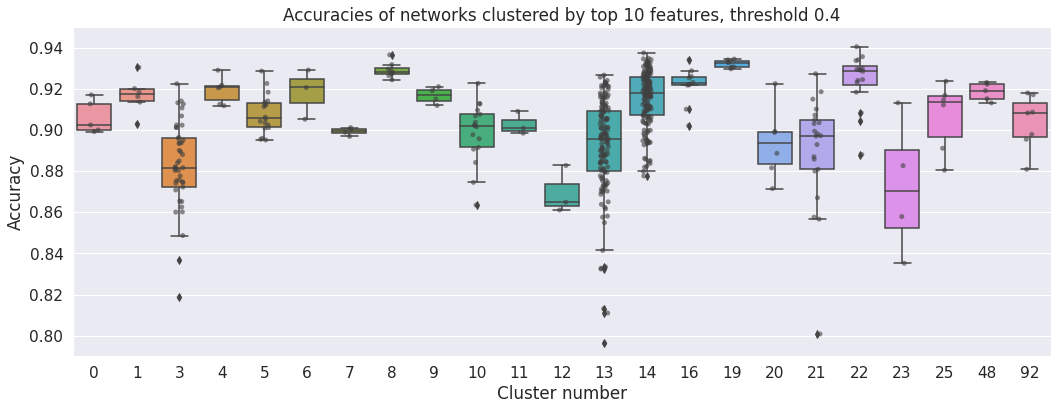

In [41]:
save_dir = '.'

sns.set(font_scale=1.4)
plt.figure(figsize=(15, 6))
plt.title(f'Accuracies of networks clustered by top {top_k} features, threshold {thres}')

sns.boxplot(data=acc_df, x='cluster', y='acc')
sns.stripplot(data=acc_df, x='cluster', y='acc', color=".25", alpha=0.6)
plt.ylim(0.79, 0.95)
plt.ylabel('Accuracy')
plt.xlabel('Cluster number')
plt.tight_layout()
plt.savefig(f"{save_dir}/cluster.png")
plt.show()

In [ ]:
nb.get_metrics_from_hash(info['hash'][0])

In [ ]:
nb.get_metrics_from_hash(info['hash'][462000])